In [19]:
from data_loader import load_orl

data = load_orl()
train, test = data["train"], data["test"]
print(f"Train set: {len(train)} samples")
print(f"Test set: {len(test)} samples")

Train set: 360 samples
Test set: 40 samples


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

Displaying 2 examples from the ORL training set:


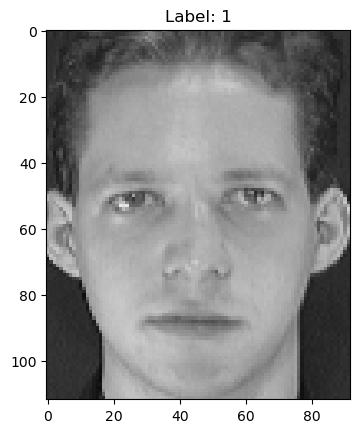

Example 1: Label = 1


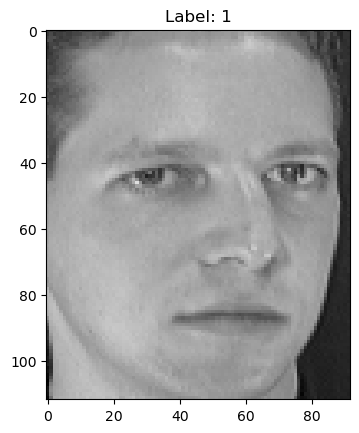

Example 2: Label = 1


In [23]:
train_data = data['train']

print("Displaying 2 examples from the ORL training set:")
for i in range(2):
    instance = train_data[i]
    image_matrix = instance['image']
    image_label = instance['label']

    plt.imshow(image_matrix, cmap='gray')
    plt.title(f"Label: {image_label}")
    plt.show()
    print(f"Example {i+1}: Label = {image_label}")

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)  # Conv1 layer: shape after conv1 is (16,110,90). after max pool: (16,55,45)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)  # Conv2 layer: shape after conv2 is (32,53,43). after max pool: (32,26,21)
        # Update this line to reflect the correct input size after convolution and pooling
        self.fc1 = nn.Linear(32 * 26 * 21, 128)  # Fully connected layer (first)
        self.fc2 = nn.Linear(128, 40)  # Output layer for 40 classes (since ORL dataset has 40 classes)

     # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Pass through conv1
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Max pooling

        # Pass through conv2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Max pooling

        # Flatten the output for the fully connected layer
        x = x.view(-1, 32 * 26 * 21)  # Flattening the output of the conv layers

        # Pass through fc1 and fc2
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)  # Softmax for multi-class classification




In [27]:
def prepare_data(raw_data, batch_size=16):
    # Step 1: Extract images and labels
    images = np.array([item['image'] for item in raw_data]).astype(np.float32)
    labels = np.array([item['label']-1 for item in raw_data]).astype(np.int64)

    # Step 2: Ensure the correct shape: swap height and width
    images = images.reshape(-1, 3, 112, 92)  # Ensure that the shape is (N, 3, 112, 92)
    
    # Use only the R channel (channel 0 in the RGB image)
    images = images[:, 0, :, :]  # Select the first channel (R channel)

    # Step 3: Normalize pixel values to [0, 1]
    images /= 255.0

    # Step 4: Reshape to (N, 1, 112, 92) for CNN input
    images = images.reshape(-1, 1, 112, 92)

    # Step 5: Convert to PyTorch tensors
    tensor_images = torch.from_numpy(images)
    tensor_labels = torch.from_numpy(labels)

    # Step 6: Create dataset and dataloader
    dataset = TensorDataset(tensor_images, tensor_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

# Load raw data
data = load_orl()

# Prepare loaders
train_loader = prepare_data(data['train'])
test_loader = prepare_data(data['test'])

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, num_epochs=20):
    model.train()  # training mode
    epoch_losses = []
    loss_history = []  # To store individual batch losses

    for epoch in range(num_epochs):
        running_loss = 0.0  
        epoch_total_loss = 0.0 
        num_batches = 0  

        for batch_idx, (inputs, labels) in enumerate(train_loader):
         
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Track losses
            running_loss += loss.item()
            epoch_total_loss += loss.item()
            loss_history.append(loss.item())
            num_batches += 1

            # Print loss for every 5 batches
            if batch_idx % 5 == 4:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                running_loss = 0.0  # Reset running loss

        # Calculate and print average loss for the current epoch
        avg_loss = epoch_total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    print("Finished Training")
    return epoch_losses, loss_history


Using device: cpu


In [31]:
# Train the model
train_losses, loss_history = train(model, train_loader, num_epochs=20)



Epoch [1/20], Batch [5/23], Loss: 0.1908
Epoch [1/20], Batch [10/23], Loss: 0.1841
Epoch [1/20], Batch [15/23], Loss: 0.1812
Epoch [1/20], Batch [20/23], Loss: 0.1773
Epoch [1/20], Average Loss: 3.6452
Epoch [2/20], Batch [5/23], Loss: 0.1625
Epoch [2/20], Batch [10/23], Loss: 0.1562
Epoch [2/20], Batch [15/23], Loss: 0.1440
Epoch [2/20], Batch [20/23], Loss: 0.1347
Epoch [2/20], Average Loss: 2.9543
Epoch [3/20], Batch [5/23], Loss: 0.1175
Epoch [3/20], Batch [10/23], Loss: 0.1136
Epoch [3/20], Batch [15/23], Loss: 0.1002
Epoch [3/20], Batch [20/23], Loss: 0.0902
Epoch [3/20], Average Loss: 2.1027
Epoch [4/20], Batch [5/23], Loss: 0.0811
Epoch [4/20], Batch [10/23], Loss: 0.0816
Epoch [4/20], Batch [15/23], Loss: 0.0672
Epoch [4/20], Batch [20/23], Loss: 0.0698
Epoch [4/20], Average Loss: 1.4698
Epoch [5/20], Batch [5/23], Loss: 0.0533
Epoch [5/20], Batch [10/23], Loss: 0.0504
Epoch [5/20], Batch [15/23], Loss: 0.0473
Epoch [5/20], Batch [20/23], Loss: 0.0356
Epoch [5/20], Average Los

In [32]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy on test set: {accuracy:.2f}%")
    return accuracy

# Usage
print("\nStarting evaluation...")
evaluate_model(model, test_loader)


Starting evaluation...
Accuracy on test set: 87.50%


87.5

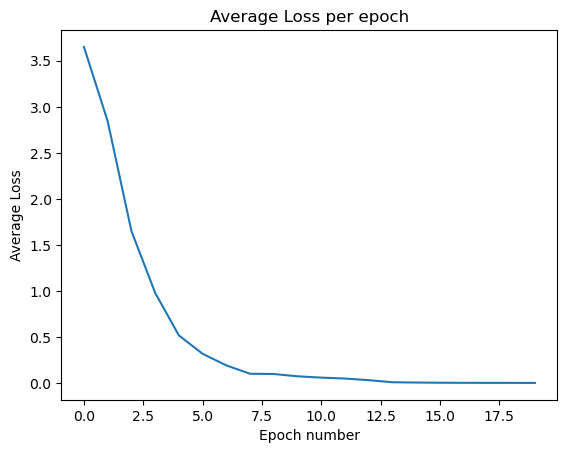

In [129]:
plt.figure()
plt.plot(train_losses)
plt.xlabel('Epoch number')
plt.ylabel('Average Loss')
plt.title('Average Loss per epoch')
plt.show()